In [235]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import missingno as msno

# Imbalanced-learn
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Interpretable machine learning
from yellowbrick.features import Rank2D
from yellowbrick.classifier import ClassificationReport, ROCAUC, PrecisionRecallCurve
from yellowbrick.model_selection import FeatureImportances

# Notebook configurations
sns.set_style('ticks')
sns.set_context("paper")
sns.set_palette("Set1")

In [236]:
# LIME
import lime
import lime.lime_tabular

In [237]:
# From nightly build of Scikit-Learn
from sklearn.inspection import permutation_importance

# Getting started

In [238]:
movies = pd.read_csv('dataset.csv')
movies.head()

,title,Production_Budget,id,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,...,cast_5,casting,composer,director,producer,screenplay,keyword_1,keyword_2,keyword_3,target
0,Edge of Tomorrow,178000000,137113,113.0,1,0,0,0,0,0,...,Jonas Armstrong,Lucinda Syson,Christophe Beck,Doug Liman,Erwin Stoff,Christopher McQuarrie,deja vu,time warp,restart,1
1,Up,175000000,14160,96.0,0,0,1,1,0,0,...,Delroy Lindo,Kevin Reher,NaN,Pete Docter,Jonas Rivera,Bob Peterson,age difference,central and south america,balloon,1
2,Cars 3,175000000,260514,102.0,0,1,1,1,0,0,...,Larry the Cable Guy,Kevin Reher,Randy Newman,Brian Fee,Kevin Reher,Bob Peterson,cgi,anthropomorphism,NaN,1
3,G.I. Joe: The Rise of Cobra,175000000,14869,118.0,1,1,0,0,0,0,...,Joseph Gordon-Levitt,Ronna Kress,Alan Silvestri,Stephen Sommers,Lorenzo Di Bonaventura,Stuart Beattie,terrorist,secret,hostage,1
4,The Mummy: Tomb of the Dragon Emperor,175000000,1735,112.0,1,1,0,0,0,0,...,Luke Ford,Ronna Kress,NaN,Rob Cohen,Stephen Sommers,Miles Millar,NaN,NaN,NaN,1


So here, we encode our `release_month` and `release_day` features using one-hot encoding. Our reason is because they represent categories instead of continuos variables. For example, in the `release_day` variable, it is wrong to assume that 25th day of a month is the average of 15th and 20th, which is how our models will interpret if they we don't encode them as categorical features properly.

# Handle missing values

In [239]:
movies['runtime'].fillna((movies['runtime'].mean()), inplace=True)

In [240]:
movies.drop(['prod_company_2', 'prod_company_3', 'casting', 'composer', 'screenplay', 'keyword_2', 'keyword_3'],
       axis=1,
       inplace=True)

In [241]:
movies.drop(['title', 'id'], inplace=True, axis=1)

In [242]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2697 entries, 0 to 2696
Data columns (total 35 columns):
Production_Budget     2697 non-null int64
runtime               2697 non-null float64
Action                2697 non-null int64
Adventure             2697 non-null int64
Animation             2697 non-null int64
Comedy                2697 non-null int64
Crime                 2697 non-null int64
Documentary           2697 non-null int64
Drama                 2697 non-null int64
Family                2697 non-null int64
Fantasy               2697 non-null int64
History               2697 non-null int64
Horror                2697 non-null int64
Music                 2697 non-null int64
Mystery               2697 non-null int64
Romance               2697 non-null int64
Science_Fiction       2697 non-null int64
TV_Movie              2697 non-null int64
Thriller              2697 non-null int64
War                   2697 non-null int64
Western               2697 non-null int64
prod_comp

# Correlation plots

### LOO-encoded correlation plot

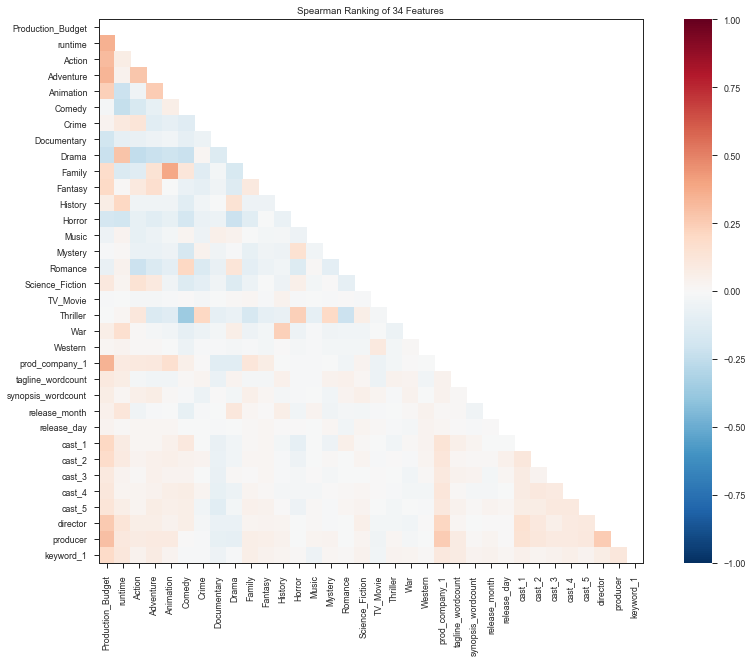

In [243]:
enc = ce.LeaveOneOutEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1']
                           ).fit_transform(movies.drop('target', axis=1), movies[['target']])

# Features correlations (Pearson)
visualizer = Rank2D(algorithm="spearman",  size=(1080, 720))
visualizer.fit_transform(enc)
visualizer.poof()

### CatBoost

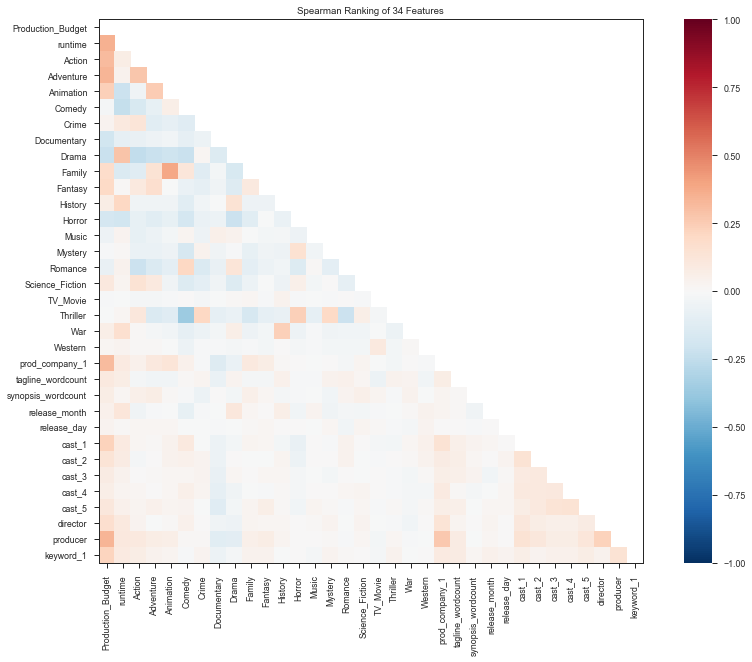

In [244]:
enc = ce.CatBoostEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1']
                           ).fit_transform(movies.drop('target', axis=1), movies[['target']])

# Features correlations (Pearson)
visualizer = Rank2D(algorithm="spearman",  size=(1080, 720))
visualizer.fit_transform(enc)
visualizer.poof()

### Target encoder

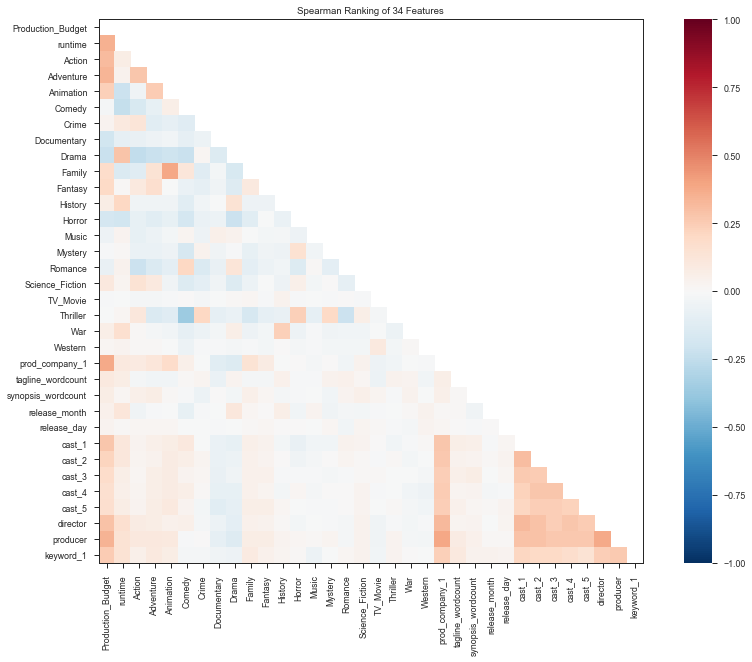

In [245]:
enc = ce.TargetEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1']
                           ).fit_transform(movies.drop('target', axis=1), movies[['target']])

# Features correlations (Pearson)
visualizer = Rank2D(algorithm="spearman",  size=(1080, 720))
visualizer.fit_transform(enc)
visualizer.poof()

# Imbalanced dataset

In [246]:
np.bincount(movies['target'])

array([1000, 1697], dtype=int64)

In [247]:
np.unique(movies['target'])

array([0, 1], dtype=int64)

# Maybe encode `release_month` and `release_day`

In [248]:
# movies = pd.get_dummies(movies, columns=['release_month', 'release_day'])

# Shuffle the data

In [249]:
# Shuffle the data to destroy order
shuffle_df = movies.sample(frac=1).reset_index(drop=True)

# Split into train and test

In [250]:
len(shuffle_df)

2697

In [251]:
# Train set
train = shuffle_df.iloc[:2000, :]
y_train = train['target']
X_train = train.drop('target', axis=1)

# Test set
test = shuffle_df.iloc[2000:, :]
y_test = test['target']
X_test = test.drop('target', axis=1)

Imbalances in train set:

In [252]:
np.bincount(y_train)

array([ 719, 1281], dtype=int64)

Imbalances in test set:

In [253]:
np.bincount(y_test)

array([281, 416], dtype=int64)

***
# LeaveOneOutEncoding

In [339]:
# Train set
X_train_enc = ce.LeaveOneOutEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1'],
                                    sigma=0.05
                                   ).fit_transform(X_train, y_train)

# Test set
X_test_enc = ce.LeaveOneOutEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1']
                                  ).fit_transform(X_test, y_test)

## Class reweight:

In [352]:
# Fit the classifier
clf = RandomForestClassifier(n_estimators=850, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_features='auto',
                             class_weight={0:4, 1:1},
                            max_depth=110,
                            criterion='entropy',
                            bootstrap=True,
                            random_state=123).fit(X_train_enc, y_train)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.64      0.65       281
           1       0.76      0.76      0.76       416

    accuracy                           0.72       697
   macro avg       0.70      0.70      0.70       697
weighted avg       0.72      0.72      0.72       697



[ROCAUC score](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics)

In [353]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.78


Unnormalized confusion matrix:
 [[181 100]
 [ 98 318]]


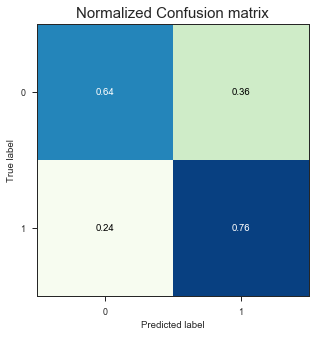

In [355]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
#ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
# ax.text(0, 1, format(cm[1, 0], fmt), ha='center', va='center', color='black')

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

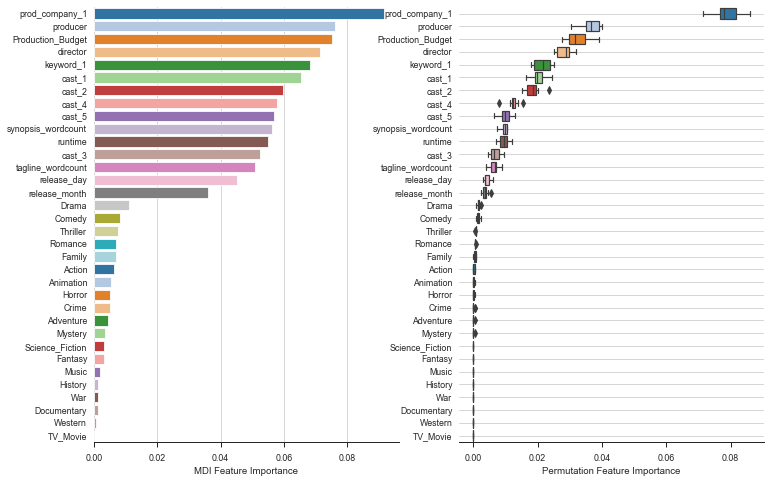

In [356]:
# Mean-decrease-in-impurity (MDI)
fi = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(fi.values, fi.index, ax=ax1, palette='tab20')
sns.despine(left=True)
ax1.xaxis.grid(True)
ax1.tick_params(axis='y', length=0)
ax1.set_xlabel('MDI Feature Importance')
#ax1.set_xticklabels(fi.index)

result = permutation_importance(clf, X_train_enc, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = np.flip(result.importances_mean.argsort())
sns.boxplot(data=result.importances[perm_sorted_idx].T, orient='h', ax=ax2, palette='tab20')
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X.columns)
ax2.yaxis.grid(True)
ax2.tick_params(axis='y', length=0)
ax2.set_xlabel('Permutation Feature Importance')
ax2.set_yticklabels(fi.index)
plt.show()

## SMOTE oversampling:

Oversampling only done on train set ([source](https://beckernick.github.io/oversampling-modeling/)):

In [357]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [358]:
np.bincount(y_train_smote)

array([1281, 1281], dtype=int64)

In [359]:
# Fit the classifier
clf = RandomForestClassifier(n_estimators=850, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_features='auto',
                            max_depth=110,
                            criterion='entropy',
                            bootstrap=True,
                            random_state=123
                            ).fit(X_train_smote, y_train_smote)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       281
           1       0.76      0.78      0.77       416

    accuracy                           0.72       697
   macro avg       0.71      0.71      0.71       697
weighted avg       0.72      0.72      0.72       697



I dropped the `prod_company_1` column and the AUC score dropped. This _could_ be an indication that our model is not just memorizing the data and using this feature to actually predict the target.

```python
In:  probs = clf.predict_proba(X_test_enc.drop('prod_company_1', axis=1))[:, 1]
     print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))
        
Out: The ROCAUC score is: 0.70
````

In [360]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.78


Unnormalized confusion matrix:
 [[181 100]
 [ 93 323]]


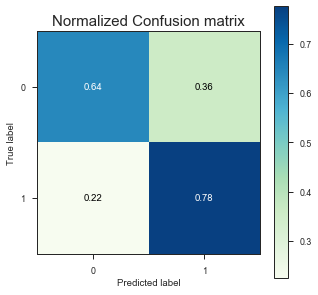

In [361]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

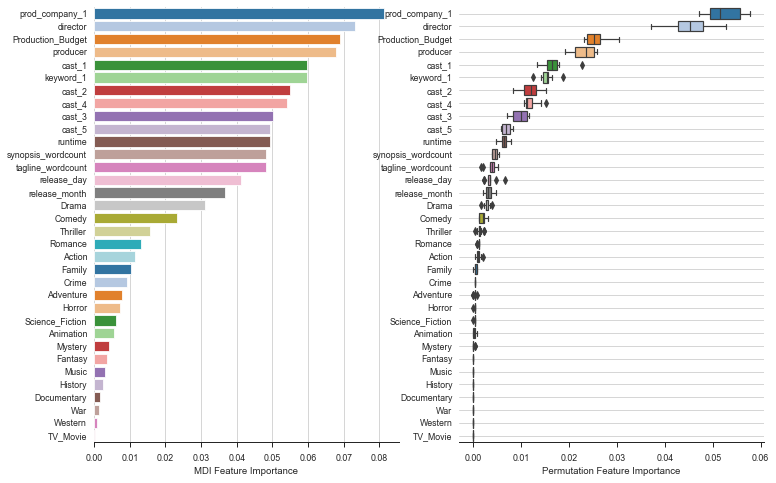

In [265]:
# Mean-decrease-in-impurity (MDI)
fi = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(fi.values, fi.index, ax=ax1, palette='tab20')
sns.despine(left=True)
ax1.xaxis.grid(True)
ax1.tick_params(axis='y', length=0)
ax1.set_xlabel('MDI Feature Importance')
#ax1.set_xticklabels(fi.index)

result = permutation_importance(clf, X_train_smote, y_train_smote, n_repeats=10, random_state=42)
perm_sorted_idx = np.flip(result.importances_mean.argsort())
sns.boxplot(data=result.importances[perm_sorted_idx].T, orient='h', ax=ax2, palette='tab20')
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X.columns)
ax2.yaxis.grid(True)
ax2.tick_params(axis='y', length=0)
ax2.set_xlabel('Permutation Feature Importance')
ax2.set_yticklabels(fi.index)
plt.show()

## ADASYN oversampling

In [362]:
X_train_adasyn, y_train_adasyn = ADASYN().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [363]:
np.bincount(y_train_adasyn)

array([1346, 1281], dtype=int64)

In [364]:
# Fit the classifier
clf = RandomForestClassifier(n_estimators=850, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_features='auto',
                            max_depth=110,
                            criterion='entropy',
                            bootstrap=True).fit(X_train_adasyn, y_train_adasyn)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65       281
           1       0.77      0.76      0.76       416

    accuracy                           0.72       697
   macro avg       0.71      0.71      0.71       697
weighted avg       0.72      0.72      0.72       697



In [365]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.77


Unnormalized confusion matrix:
 [[185  96]
 [ 99 317]]


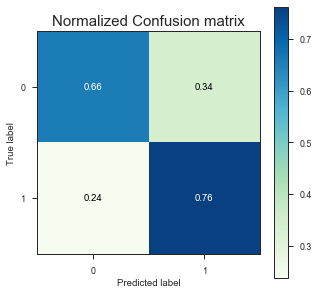

In [366]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

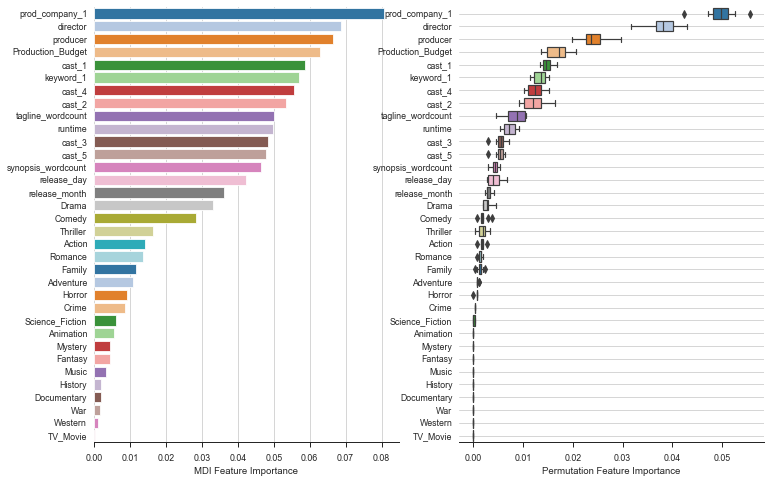

In [271]:
# Mean-decrease-in-impurity (MDI)
fi = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(fi.values, fi.index, ax=ax1, palette='tab20')
sns.despine(left=True)
ax1.xaxis.grid(True)
ax1.tick_params(axis='y', length=0)
ax1.set_xlabel('MDI Feature Importance')
#ax1.set_xticklabels(fi.index)

result = permutation_importance(clf, X_train_adasyn, y_train_adasyn, n_repeats=10, random_state=42)
perm_sorted_idx = np.flip(result.importances_mean.argsort())
sns.boxplot(data=result.importances[perm_sorted_idx].T, orient='h', ax=ax2, palette='tab20')
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X.columns)
ax2.yaxis.grid(True)
ax2.tick_params(axis='y', length=0)
ax2.set_xlabel('Permutation Feature Importance')
ax2.set_yticklabels(fi.index)
plt.show()

***
# CatBoost encoding

In [380]:
# Train set
X_train_enc = ce.CatBoostEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1'],
                                    sigma=0.05
                                   ).fit_transform(X_train, y_train)

# Test set
X_test_enc = ce.CatBoostEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1']
                                  ).fit_transform(X_test, y_test)

## Class reweight

In [381]:
# Fit the classifier
clf = RandomForestClassifier(n_estimators=850, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_features='auto',
                             class_weight={0:3, 1:1},
                            max_depth=110,
                            criterion='entropy',
                            bootstrap=True,
                            random_state=123).fit(X_train_enc, y_train)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.63      0.62       281
           1       0.75      0.74      0.74       416

    accuracy                           0.69       697
   macro avg       0.68      0.68      0.68       697
weighted avg       0.69      0.69      0.69       697



In [382]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.75


Unnormalized confusion matrix:
 [[177 104]
 [110 306]]


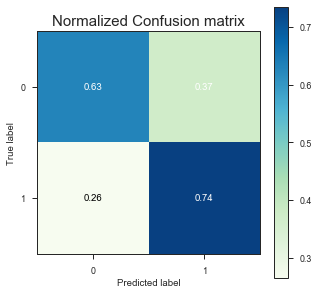

In [383]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

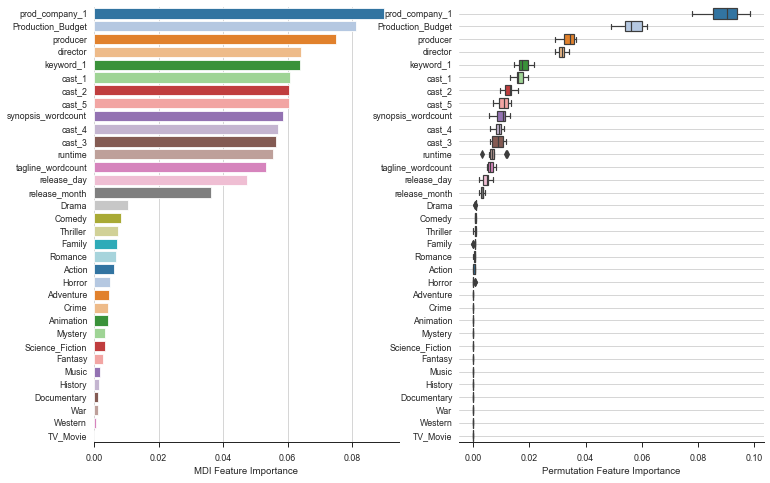

In [384]:
# Mean-decrease-in-impurity (MDI)
fi = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(fi.values, fi.index, ax=ax1, palette='tab20')
sns.despine(left=True)
ax1.xaxis.grid(True)
ax1.tick_params(axis='y', length=0)
ax1.set_xlabel('MDI Feature Importance')
#ax1.set_xticklabels(fi.index)

result = permutation_importance(clf, X_train_enc, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = np.flip(result.importances_mean.argsort())
sns.boxplot(data=result.importances[perm_sorted_idx].T, orient='h', ax=ax2, palette='tab20')
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X.columns)
ax2.yaxis.grid(True)
ax2.tick_params(axis='y', length=0)
ax2.set_xlabel('Permutation Feature Importance')
ax2.set_yticklabels(fi.index)
plt.show()

***
# APPENDIX: Doing resampling first and then encoding

In [407]:
# from imblearn.over_sampling import SMOTENC

In [413]:
# X_train.columns

Index(['Production_Budget', 'runtime', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science_Fiction',
       'TV_Movie', 'Thriller', 'War', 'Western', 'prod_company_1',
       'tagline_wordcount', 'synopsis_wordcount', 'release_month',
       'release_day', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5',
       'director', 'producer', 'keyword_1'],
      dtype='object')

In [417]:
# X_train = X_train.fillna('')

In [418]:
# X_train_smotenc, y_train_smotenc = SMOTENC(categorical_features=[21, 26, 27, 28, 29, 30, 31, 32, 33])\
                                    .fit_resample(X_train, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [421]:
# X_train_smotenc

array([[150000.0, 85.0, 0.0, ..., 'John Carney', 'Martina Niland',
        'rock and roll'],
       [24000000.0, 105.0, 0.0, ..., 'Tim Story', 'William Packer', ''],
       [9000000.0, 96.0, 1.0, ..., 'Ekachai Uekrongtham',
        'Craig Baumgarten', 'martial arts'],
       ...,
       [16000000.0, 142.80479703560582, 0.0, ..., 'Tommy Lee Jones',
        'Bobby Cohen', ''],
       [6654507.929474896, 96.0, 0.0, ..., 'Oren Moverman',
        'Ridley Scott', ''],
       [12000000.0, 91.55819002051885, 0.0, ..., 'Lawrence Kasdan',
        'Neil Jordan', 'aftercreditsstinger']], dtype=object)

In [423]:
# # Train set
# X_train_enc = ce.CatBoostEncoder(cols=None,
#                                     sigma=0.05
#                                    ).fit_transform(X_train_smotenc, y_train_smotenc)

# # Test set
# X_test_enc = ce.CatBoostEncoder(cols=None
#                                   ).fit_transform(X_test, y_test)

In [425]:
# # Fit the classifier
# clf = RandomForestClassifier(n_estimators=850, 
#                             min_samples_split=2,
#                             min_samples_leaf=2,
#                             max_features='auto',
#                             max_depth=110,
#                             criterion='entropy',
#                             bootstrap=True).fit(X_train_enc, y_train_smotenc)

# # Get predictions
# y_pred = clf.predict(X_test_enc)

# # Print classification_report
# print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.12      0.21       281
           1       0.62      0.96      0.75       416

    accuracy                           0.62       697
   macro avg       0.65      0.54      0.48       697
weighted avg       0.65      0.62      0.53       697



In [426]:
# probs = clf.predict_proba(X_test_enc)[:, 1]
# print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.72


***

## SMOTE oversampling

In [385]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [386]:
np.bincount(y_train_smote)

array([1281, 1281], dtype=int64)

In [387]:
# Fit the classifier
clf = RandomForestClassifier(n_estimators=850, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_features='auto',
                            max_depth=110,
                            criterion='entropy',
                            bootstrap=True).fit(X_train_smote, y_train_smote)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       281
           1       0.75      0.72      0.73       416

    accuracy                           0.69       697
   macro avg       0.68      0.68      0.68       697
weighted avg       0.69      0.69      0.69       697



In [388]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.75


Unnormalized confusion matrix:
 [[179 102]
 [117 299]]


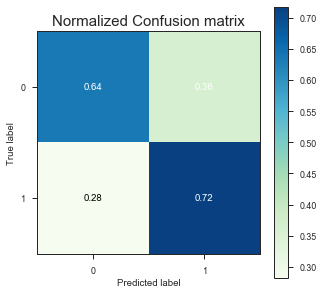

In [389]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

## ADASYN oversampling

In [390]:
X_train_adasyn, y_train_adasyn = ADASYN().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [391]:
np.bincount(y_train_adasyn)

array([1346, 1281], dtype=int64)

In [392]:
# Fit the classifier
clf = RandomForestClassifier(n_estimators=850, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_features='auto',
                            max_depth=110,
                            criterion='entropy',
                            bootstrap=True).fit(X_train_adasyn, y_train_adasyn)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63       281
           1       0.76      0.70      0.73       416

    accuracy                           0.69       697
   macro avg       0.68      0.68      0.68       697
weighted avg       0.69      0.69      0.69       697



In [393]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.75


Unnormalized confusion matrix:
 [[187  94]
 [125 291]]


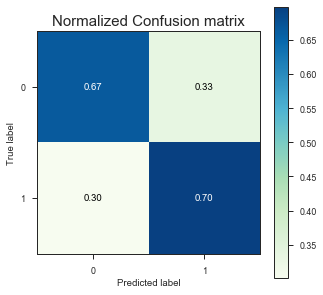

In [394]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

***
# Target encoding

All of these below are overfit. We will just use them as they are as an example of overfitting.

In [395]:
# Train set
X_train_enc = ce.TargetEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                  'director', 'producer', 'keyword_1'],
                               smoothing=200
                                   ).fit_transform(X_train, y_train)

# Test set
X_test_enc = ce.TargetEncoder(cols=['prod_company_1', 'cast_1', 'cast_2', 
                                  'cast_3', 'cast_4', 'cast_5',
                                    'director', 'producer', 'keyword_1']
                                  ).fit_transform(X_test, y_test)

## Class reweight

In [396]:
# Fit the classifier
clf = RandomForestClassifier(n_estimators=850, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_features='auto',
                             class_weight={0:20, 1:1},
                            max_depth=110,
                            criterion='entropy',
                            bootstrap=True,
                            random_state=123).fit(X_train_enc, y_train)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       281
           1       0.96      0.88      0.92       416

    accuracy                           0.91       697
   macro avg       0.90      0.91      0.90       697
weighted avg       0.91      0.91      0.91       697



In [397]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.95


Unnormalized confusion matrix:
 [[267  14]
 [ 51 365]]


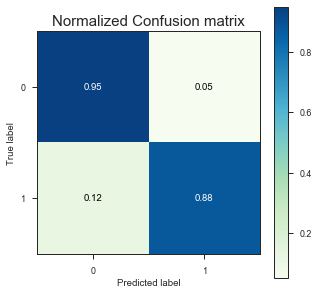

In [398]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

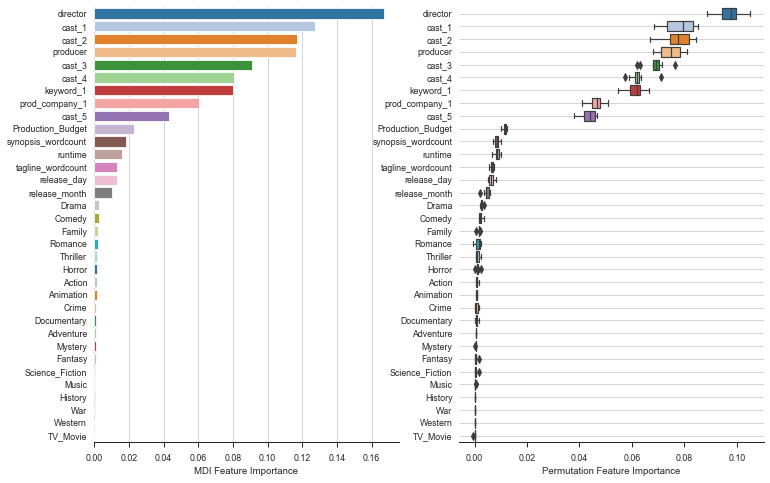

In [204]:
# Mean-decrease-in-impurity (MDI)
fi = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(fi.values, fi.index, ax=ax1, palette='tab20')
sns.despine(left=True)
ax1.xaxis.grid(True)
ax1.tick_params(axis='y', length=0)
ax1.set_xlabel('MDI Feature Importance')
#ax1.set_xticklabels(fi.index)

result = permutation_importance(clf, X_train_enc, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = np.flip(result.importances_mean.argsort())
sns.boxplot(data=result.importances[perm_sorted_idx].T, orient='h', ax=ax2, palette='tab20')
# ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X.columns)
ax2.yaxis.grid(True)
ax2.tick_params(axis='y', length=0)
ax2.set_xlabel('Permutation Feature Importance')
ax2.set_yticklabels(fi.index)
plt.show()

## SMOTE resampling

In [399]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [400]:
np.bincount(y_train_smote)

array([1281, 1281], dtype=int64)

In [401]:
# Fit the classifier
clf = RandomForestClassifier(n_estimators=850, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_features='auto',
                            max_depth=110,
                            criterion='entropy',
                            bootstrap=True,
                            random_state=123).fit(X_train_smote, y_train_smote)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       281
           1       0.98      0.83      0.90       416

    accuracy                           0.89       697
   macro avg       0.89      0.90      0.89       697
weighted avg       0.90      0.89      0.89       697



In [402]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.94


Unnormalized confusion matrix:
 [[274   7]
 [ 74 342]]


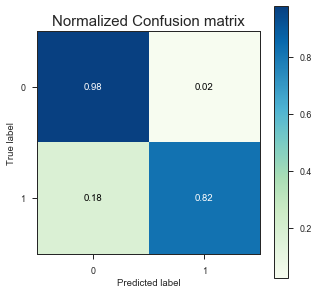

In [294]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

## ADASYN resampling

In [403]:
X_train_adasyn, y_train_adasyn = ADASYN().fit_resample(X_train_enc, y_train)

C:\Users\Sina\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [404]:
np.bincount(y_train_adasyn)

array([1346, 1281], dtype=int64)

In [405]:
# Fit the classifier
clf = RandomForestClassifier(n_estimators=850, 
                            min_samples_split=2,
                            min_samples_leaf=2,
                            max_features='auto',
                            max_depth=110,
                            criterion='entropy',
                            bootstrap=True,
                            random_state=123).fit(X_train_adasyn, y_train_adasyn)

# Get predictions
y_pred = clf.predict(X_test_enc)

# Print classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       281
           1       0.98      0.81      0.89       416

    accuracy                           0.88       697
   macro avg       0.88      0.90      0.88       697
weighted avg       0.90      0.88      0.88       697



In [406]:
probs = clf.predict_proba(X_test_enc)[:, 1]
print('The ROCAUC score is: {:.2f}'.format(roc_auc_score(y_test, probs)))

The ROCAUC score is: 0.94


Unnormalized confusion matrix:
 [[272   9]
 [ 75 341]]


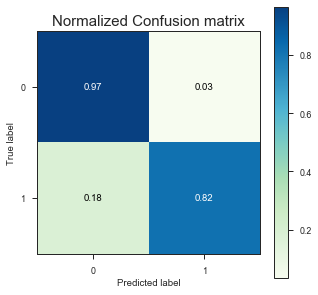

In [299]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       ylabel='True label',
       xlabel='Predicted label')
ax.set_title('Normalized Confusion matrix', fontsize=15)

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

np.set_printoptions(precision=2)

print('Unnormalized confusion matrix:\n', confusion_matrix(y_test, y_pred))
plt.show()

# APPENDIX: Additive smoothing

[source](https://maxhalford.github.io/blog/target-encoding-done-the-right-way/)

In [149]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [110]:
X_train.columns

Index(['Production_Budget', 'runtime', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science_Fiction',
       'TV_Movie', 'Thriller', 'War', 'Western', 'prod_company_1',
       'tagline_wordcount', 'synopsis_wordcount', 'release_month',
       'release_day', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5',
       'director', 'producer', 'keyword_1'],
      dtype='object')

In [157]:
# Train set
train = shuffle_df.iloc[:2000, :]

# Test set
test = shuffle_df.iloc[2000:, :]

In [158]:
cat_cols = ['prod_company_1', 'cast_1', 'cast_2', 'cast_3', 'cast_4', 'cast_5', 'director', 'producer', 'keyword_1']
for col in cat_cols:
    train.loc[:, col] = calc_smooth_mean(train, by=col, on='target', m=200)

In [159]:
for col in cat_cols:
    test.loc[:, col] = calc_smooth_mean(test, by=col, on='target', m=200)

In [160]:
# Train set
y_train = train['target']
X_train = train.drop('target', axis=1)

# Test set
y_test = test['target']
X_test = test.drop('target', axis=1)

In [161]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [162]:
test

,Production_Budget,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,...,release_day,cast_1,cast_2,cast_3,cast_4,cast_5,director,producer,keyword_1,target
2000,28000000,110.0,0,0,0,1,0,0,1,0,...,12,0.624295,0.627401,0.627401,0.627401,0.627401,0.631072,0.638608,0.627401,1
2001,2000000,100.0,0,0,0,0,0,0,1,0,...,20,0.627401,0.627401,0.627401,0.627401,0.627401,0.627401,0.626146,0.627401,1
2002,25000000,97.0,0,0,0,1,0,0,1,0,...,13,0.627401,0.626146,0.627401,0.627401,0.624295,0.627401,0.643370,0.638201,1
2003,55000000,214.0,0,0,0,0,0,0,1,0,...,21,0.622426,0.622426,0.622426,0.624295,0.622426,0.622426,0.622426,0.622426,0
2004,40000000,111.0,0,1,0,0,0,0,1,0,...,22,0.619345,0.622426,0.622426,0.622426,0.622426,0.622426,0.622426,0.622426,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,90000000,128.0,0,0,0,0,1,0,0,0,...,8,0.626146,0.627401,0.627401,0.627401,0.627401,0.627401,0.643370,0.617740,1
2693,55000000,91.0,0,0,1,1,0,0,0,1,...,30,0.624295,0.626146,0.627401,0.627401,0.629246,0.627401,0.632880,0.638201,1
2694,12000000,99.0,0,0,0,0,0,0,1,0,...,28,0.627401,0.629246,0.627401,0.627401,0.627401,0.627401,0.631072,0.627401,1
2695,30000,89.0,0,0,0,1,0,0,1,0,...,20,0.627401,0.627401,0.627401,0.627401,0.627401,0.627401,0.627401,0.627401,1


# Appendix: Randomized search

In [ ]:
# class_weight = ['balanced', {0:2, 1:1}, {0:5, 1:1}, {0:10, 1:1}] # class of reweight

# n_estimators = [int(x) for x in np.linspace(start=10, stop=1000, num=100)] # number of trees

# criterion = ['gini', 'entropy']

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
# max_depth.append(None)

# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10, 12, 14, 18, 20]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4, 6, 8, 10]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# oob_score = [True, False]

# ccp_alpha = [int(x) for x in np.linspace(0, 1, num = 100)]

# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'class_weight': class_weight,
#                'oob_score': oob_score,
#                'ccp_alpha': ccp_alpha,
#                'criterion': criterion,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [ ]:
# clf = RandomForestClassifier()
# clf_random = RandomizedSearchCV(estimator=clf, 
#                                 param_distributions=random_grid, 
#                                 n_iter=100, 
#                                 cv=10, 
#                                 verbose=2, 
#                                 random_state=42, 
#                                 n_jobs=-1)# Fit the random search model

# clf_random.fit(X_train_enc, y_train)

In [ ]:
# clf_random.best_params_